## Thermodynamics
### Phase equilibrium
##### UNIFAC method - Activity coefficient

In [1]:
import numpy as np
import pandas as pd
import CoolProp.CoolProp as CP
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Molecular group data, extracted from the course material.

In [2]:
groups = { # main: {secondary i:[molecule,R,Q],secondary i+1:[molécula,R,Q],etc}
    1: {1:['CH3',0.9011,0.848],2:['CH2',0.6744,0.540],3:['CH',0.4469,0.228],4:['C',0.2195,0]},
    2: {5:['CH2CH',1.3454,1.176],6:['CHCH',1.1167,0.867],7:['CH2C',1.1173,0.988],8:['CHC',0.8886,0.676],70:['CC',0.6605,0.485]},
    3: {9:['ACH',0.5313,0.400],10:['AC',0.3652,0.120]},
    4: {11:['ACCH3',1.2663,0.968],12:['ACCH2',1.0396,0.660],13:['ACCH',0.8121,0.348]},
    5: {14:['OH',1.000,1.200]},
    6: {15:['CH3OH',1.4311,1.432]},
    7: {16:['H2O',0.9200,1.400]},
    8: {17:['ACOH',0.8952,0.680]},
    9: {18:['CH3CO',1.6724,1.488],19:['CH2CO',1.4457,1.180]},
    10: {20:['CHO',0.9980,0.948]},
    11: {21:['CH3COO',1.9031,1.728],22:['CH2COO',1.6764,1.420]},
    12: {23:['HCOO',1.2420,1.188]}
}
g_groups = {}
for i in groups.values():
    g_groups.update(i)
    
a_mn = pd.read_csv('a-mn.csv', sep=';', index_col=0)
a_mn.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
1,0.00,8602.000,61.13,76.50,986.5,697.2,1318.0,1333.0,476.40,677.0,232.100,507.0,251.50,391.500,255.70,206.60,920.70,287.800
2,-35.36,0.000,38.81,74.15,524.1,787.6,270.6,526.1,182.60,448.8,37.850,333.5,214.50,240.900,163.90,61.11,749.30,2811.500
3,-11.12,3.446,0.00,167.00,636.1,637.4,903.8,1329.0,25.77,347.3,5.994,287.1,32.14,161.700,122.80,9049.00,648.20,-4.449
4,-69.70,-113.600,-146.80,0.00,803.2,603.3,5695.0,4.9,-52.10,586.8,5688.000,197.8,213.10,19.020,-49.29,23.50,663.20,52.800
5,156.40,457.000,89.60,25.82,0.0,-137.1,353.5,-259.7,84.00,-203.6,101.100,267.8,28.06,8.642,42.70,-3210.00,-52.39,170.000


## UNIFAC Method
#### >> brief explanation goes here <<

**Molecule class and it's methods:**
* initializer - molecular group code and its respective amount

\> **combinatiorial activity coefficient** - _the easy one, be like it_
* r, q and l coefficients
* $\phi$ and $\theta$ factors
* $\gamma^c$- combinatorial activity coefficient

\> **residual activity coefficient** - _the hard one, don't be this one_
* $\psi$ factor
* $\Gamma_k$, X and $\theta$
* $\Gamma_k^i$, $X^i$ and $\theta^i$
        
$$\ln{\gamma^r} = \sum \nu_k (\ln\Gamma_k - \ln\Gamma_k^i)$$

\> **acitivity coefficient**

$$\ln{\gamma} = \ln{\gamma^c} + \ln{\gamma^r}$$

In [205]:
class molecule():
    def __init__(self,molGroups):
        self.g = molGroups.keys()
        self.v = molGroups.values()
        self.groups = molGroups        
        
    def rql(self):
        z,r,q = 10,0,0        
        num = len(self.g)
        if num > 1:
            for i,k in zip(self.g,self.v):
                r += g_groups[i][1] * k
                q += g_groups[i][2] * k
        else:
            r = g_groups[tuple(self.g)[0]][1] * tuple(self.v)[0]
            q = g_groups[tuple(self.g)[0]][2] * tuple(self.v)[0]
        self.l = 0.5 * z * (r - q) - (r - 1)
        self.r,self.q = r,q
        return(self.r,self.q,self.l)
    
    def phi_theta(self, fluid):        
        self.x, fluid.x = x, (1-x)
        phi,theta = {},{}       
        phi[self] = self.r * x / (self.r * self.x + fluid.r * fluid.x)
        phi[fluid] = fluid.r * (1 - x) / (self.r * self.x + fluid.r * fluid.x)
        theta[self] = self.q * x / (self.q * x + fluid.q * (1 - x))
        theta[fluid] = fluid.q * (1 - x) / (self.q * self.x + fluid.q * fluid.x)
        self.phi, self.theta = phi[self], theta[self]
        fluid.phi, fluid.theta = phi[fluid], theta[fluid]
        return(self.phi, self.theta, fluid.phi, fluid.theta)
    
    def combinatorial(self, fluid):
        self.phi_theta(fluid)
        self.x, fluid.x = x, (1-x)
        self.gamma_c_ln = np.log(self.phi / self.x) + 5 * self.q * np.log(self.theta / self.phi) + \
                    self.l - (self.phi / self.x) * ( fluid.x * fluid.l + self.x * self.l )
        fluid.gamma_c_ln = np.log(fluid.phi / fluid.x) + 5 * fluid.q * np.log(fluid.theta / fluid.phi) + \
                    fluid.l - (fluid.phi / fluid.x) * ( self.x * self.l + fluid.x * fluid.l )
        self.gamma = np.exp(self.gamma_c_ln)
        fluid.gamma = np.exp(fluid.gamma_c_ln)
        return(self.gamma_c_ln, fluid.gamma_c_ln)    
        
    def psi_mod(self, fluid, pairs):
        self.p = tuple([(i,j) for i in pairs for j in pairs])
        a, psi = {}, {}
        for i in self.p:
            j = (i[0]-1,i[1]-1)
            a[i] = a_mn.iat[j]
            psi[i] = np.exp(-a_mn.iat[j] / T)
        self.a_k, self.a_v, self.a = a.keys(), a.values(), a
        self.psi_k, self.psi_v, self.psi = psi.keys(), psi.values(), psi
        self.psi_matrix = np.reshape(np.array([self.psi[i] for i in self.p]),(len(pairs),len(pairs)))
        return(self.a_k, self.a_v, self.a)
        return(self.psi_k, self.psi_v, self.psi)
        return(self.p)
        return(self.psi_matrix)
    
    def X_mod(self, fluid):            
        self.x, fluid.x = x, (1-x)
        den = sum([self.groups[k] for k in list(self.g)]) * self.x + \
              sum([fluid.groups[k] for k in list(fluid.g)]) * fluid.x
        X = []
        g_list = list(set([i for j in [list(self.g),list(fluid.g)] for i in j]))
        for k in sorted(g_list):
            nom = 0
            if k in list(self.g):
                nom += self.groups[k] * self.x
            if k in list(fluid.g):
                nom += fluid.groups[k] * fluid.x
            X.append(nom / den)      
        self.X = X       
        return(self.X)
    
    def X_mod_i(self, fluid):   
        v1, v2 = list(self.v), list(fluid.v)
        Xi = np.array(v1) / sum(v1), np.array(v2) / sum(v2)
        self.Xi = Xi
        return(self.Xi)
    
    def Theta_mod(self, fluid):
        Xx = self.X_mod(fluid)
        g_list = list(set([i for j in [list(self.g),list(fluid.g)] for i in j]))
        nom = np.multiply(np.transpose(Xx) ,np.array([g_groups[k][2] for k in sorted(g_list)]))
        den = sum(nom)
        self.Theta = np.divide(nom, den)
        return(self.Theta)
    
    def Theta_mod_i(self, fluid):
        X_i = self.X_mod_i(fluid)
        g1, g2 = list(self.g), list(fluid.g)
        Q1, Q2 = [g_groups[i][2] for i in g1], [g_groups[i][2] for i in g2]
        #print(X_i,'\n',Q1,'\n',Q2)
        nom1, nom2 = np.multiply(X_i[0],Q1), np.multiply(X_i[1],Q2)
        den1, den2 = sum(nom1), sum(nom2)
        self.Theta1, self.Theta2 = nom1 / den1, nom2 / den2
        return(self.Theta1, self.Theta2)
    
    def Gamma_k(self, fluid):        
        t = self.Theta_mod(fluid)
        g_list = list(set([i for j in [list(self.g),list(fluid.g)] for i in j]))
        Q = [g_groups[k][2] for k in sorted(g_list)]
        YY = self.psi_matrix
        nTheta = np.reshape(t,(len(YY),1))
        pt = np.multiply(YY,nTheta)
        pt2 = np.multiply(YY,t)
        denom = np.sum(pt,axis=0)
        gam = 1 - np.log(denom) - np.sum(np.divide([i for i in pt2],denom),axis=1)
        self.gamma_k_ln = np.multiply(Q,gam)
        return(self.gamma_k_ln)
    
    def Gamma_k_i(self, fluid):
        t1, t2 = self.Theta_mod_i(fluid)
        #if len(t1) < max(len(t1),len(t2)):
        #    t1 = np.append(t1,0)
        #if len(t2) < max(len(t1),len(t2)):
        #    t2 = np.append(t2,0)
        g1, g2 = list(self.g), list(fluid.g)
        Q1, Q2 = [g_groups[i][2] for i in g1], [g_groups[i][2] for i in g2]
        YY = self.psi_matrix
        #print(t1,'\n',t2,'\n',Y)
        a, b = np.multiply([YY[0,0],YY[2,0]], t1), np.multiply([YY[0,2],YY[2,2]], t1)
        c, d = np.multiply([YY[0,0],YY[1,0]], t2), np.multiply([YY[0,1],YY[1,1]], t2)
        e, f = np.multiply([YY[0,0],YY[0,2]], t1), np.multiply([YY[2,0],YY[2,2]], t1)
        g, h = np.multiply([YY[0,0],YY[0,1]], t1), np.multiply([YY[1,0],YY[1,1]], t2)
        gamma_1 = Q1[0] * (1 - np.log(sum(a)) - e[0] / sum(a) - e[1] / sum(b) )
        gamma_2 = Q1[1] * (1 - np.log(sum(b)) - f[0] / sum(a) - f[1] / sum(b) )
        gamma_3 = Q2[0] * (1 - np.log(sum(c)) - g[0] / sum(c) - g[1] / sum(d) )
        gamma_4 = Q2[1] * (1 - np.log(sum(d)) - h[0] / sum(c) - h[1] / sum(d) )        
        return(gamma_1,gamma_2,gamma_3,gamma_4)
    
    def residual(self, fluid):
        v1, v2 = list(self.v), list(fluid.v)
        k_i = self.Gamma_k_i(fluid)
        g1 = np.array([self.Gamma_k(fluid)[0],self.Gamma_k(fluid)[2]])
        g2 = np.array([self.Gamma_k(fluid)[0],self.Gamma_k(fluid)[1]])
        gg1 = g1-k_i[:2]
        gg2 = g2-k_i[2:]
        gamma_r_ln_1 = sum(np.multiply(v1,gg1))
        gamma_r_ln_2 = sum(np.multiply(v2,gg2))
        gamma_r_1, gamma_r_2 = np.exp(gamma_r_ln_1), np.exp(gamma_r_ln_2)
        return(gamma_r_ln_1, gamma_r_ln_2)
    
    def Gamma(self, fluid):
        yr = self.residual(fluid)
        print(x,'\n',yr,'\n')
        yc = self.combinatorial(fluid)
        #print(yc,'\n')
        y_ln = np.add(yr, yc)
        #print(y_ln)
        self.y = np.exp(y_ln)
        return(self.y)

**Peng-Robinson Equation**

\begin{equation}
p = \frac{RT}{v-b} - \frac{a}{v^2+2bv-b^2}
\end{equation}

where:
\begin{equation}
a_i = \frac{0.45724 R^2 T_c^2}{p_c} \times \left[1 + (0.37464 + 1.54226 \omega - 0.26992 \omega^2)(1-\sqrt{\frac{T}{T_c}})\right]^2
\end{equation}

or
\begin{equation}
a_i = \frac{0.45724 R^2 T_c^2}{p_c} \times \alpha(T)
\end{equation}

with

\begin{equation}
\alpha\left(T\right) = \left[1 + (0.37464 + 1.54226 \omega - 0.26992 \omega^2)(1-\sqrt{\frac{T}{T_c}})\right]^2
\end{equation}

\begin{equation}
b_i = \frac{0.07780 R T_c}{p_c}
\end{equation}

**Isobutane** - pure
* Properties: $p_{sat}$,$T_c$, $p_c$, $\omega$
* Constants: a, b, $\alpha(T)$

In [117]:
R = 8.314
T = 303.14
kPatommHg = 760 / 101.325
p_sat_but = CP.PropsSI('P','T',T,'Q',0,'Isobutane') / 1000
p_crit_but = CP.PropsSI('pcrit','Isobutane') / 1000
T_crit_but = CP.PropsSI('Tcrit','Isobutane')
w_but = CP.PropsSI('acentric','T',T,'Q',0,'Isobutane')
##
alpha_but = 1 + (0.37464 + 1.54226 * w_but - 0.26992 * w_but**2) * (1 - np.sqrt(T / T_crit_but))
a_but = 0.45724 *( (R * T_crit_but) ** 2 / p_crit_but) * alpha_but**2 / 1000
b_but = 0.07780 * R * T_crit_but / p_crit_but / 1000
print(p_sat_but, b_but)

404.6085477090365 7.268887954158169e-05


**Propane** - pure
* Properties: $p_{sat}$,$T_c$, $p_c$, $\omega$
* Constants: a, b, $\alpha(T)$

In [118]:
p_sat_prop = CP.PropsSI('P','T',T,'Q',0,'Propane') / 1000
p_crit_prop = CP.PropsSI('pcrit','Propane') / 1000
T_crit_prop = CP.PropsSI('Tcrit','Propane')
w_prop = CP.PropsSI('acentric','T',T,'Q',0,'Propane')
##
alpha_prop = 1 + (0.37464 + 1.54226 * w_prop - 0.26992 * w_prop**2) * (1 - np.sqrt(T / T_crit_prop))
a_prop = 0.45724 *( (R * T_crit_prop) ** 2 / p_crit_prop) * alpha_prop**2 / 1000
b_prop = 0.07780 * R * T_crit_prop / p_crit_prop / 1000
print(p_sat_prop, b_prop)

(a_prop - np.sqrt(a_prop*a_but)) * 4.18

1078.7296654406125 5.627955701637185e-05


-1.0916966633165299

**Mixture**

\begin{equation}
a = \sum\limits_j \sum\limits_i x_i x_j \sqrt{(a_i a_j)}
\end{equation}

\begin{equation}
b = \sum\limits_i x_i b_i
\end{equation}

i.e

\begin{equation}
p = \frac{\left(N_1 + N_2 \right)RT}{V-N_1 b_1 - N_2 b_2} - \frac{N_1^2 a_1 + N_1 N_2 \sqrt{a_1 a_2} + N_2^2 a_2}{V^2+2 \left(N_1 b_1 + N_2 b_2 \right)V-\left(N_1 b_1 + N_2 b_2 \right)^2}
\end{equation}

In [119]:
x_molar = np.linspace(0.1,0.9,10)
a = x_molar ** 2 * a_prop + \
    x_molar * (1 - x_molar) * np.sqrt(a_prop * a_but) +\
    (1 - x_molar) ** 2 * a_but
b = x_molar * b_prop + (1 - x_molar) * b_but

We are actually interested in finding the following derivative:

\begin{equation}
v_i = \frac{\partial V}{\partial N_i}\bigg|_{T,p,N_{j\neq i}}
\end{equation}

since the fugacity coefficient $\phi$ is defined as

\begin{equation}
\ln{\phi_i} = - \int\limits_0^{p}\left(\frac{v_i}{RT}-\frac{1}{p}\right)\mathrm{d}p
\end{equation}

given that the Peng-Robinson equation is an implicit equation for V, that is quite complex. Thanks to math we can employ the inverse derivative rule, which leads to

\begin{equation}
\frac{\partial V}{\partial N_i}\bigg|_{T,p,N_{j\neq i}} = -\frac{\frac{\partial p}{\partial N_i}\bigg|_{T,V,N_{j\neq i}}}{\frac{\partial p}{\partial V}\bigg|_{T,N_i}}
\end{equation}

\begin{align}
\frac{\partial p}{\partial N_1}\bigg|_{T,V,N_2} &= \frac{RT \left(V + N_2 b_1 - N_2 b_2\right)}{\left(V - N_1 b_1 - N_2 b_2\right)^2} - \frac{2 N_1 a_1 + N_2\sqrt{a_1 a_2}}{V^2 + 2 V \left(N_1 b_1 + N_2 b_2\right) -\left(N_1 b_1 + N_2 b_2\right)^2} +\\
&\frac{2\left(N_1^2 a_1 + N_1 N_2 \sqrt{a_1 a_2} + N_2^2 a_2\right)\left[V b_1 - b_1\left(N_1 b_1 + N_2 b_2\right)\right]}{\left[V^2 + 2 V \left(N_1 b_1 + N_2 b_2\right) -\left(N_1 b_1 + N_2 b_2\right)^2\right]^2}
\end{align}

\begin{equation}
{\frac{\partial p}{\partial V}\bigg|_{T,N_i}} = -\frac{\left(N_1 + N_2\right) RT}{\left(V -N_1 b_1- N_2 b_2\right)^2} + \frac{2\left(N_1^2 a_1 + N_1 N_2 \sqrt{a_1 a_2} + N_2^2 a_2\right)\left[V + \left(N_1 b_1 + N_2 b_2\right)\right]}{\left[V^2 + 2 V \left(N_1 b_1 + N_2 b_2\right) - \left(N_1 b_1 + N_2 b_2\right) \right]^2}
\end{equation}

*--------------------------*

\begin{align}
\frac{\partial V}{\partial N_1}\bigg|_{T,p,N_2} = \frac{RT \left(V + N_2 b_1 - N_2 b_2\right)\left[V^2 + 2 V \left(N_1 b_1 + N_2 b_2\right) -\left(N_1 b_1 + N_2 b_2\right)^2\right]^2 -\\
\left(2 N_1 a_1 + N_2\sqrt{a_1 a_2}\right)\left[V^2 + 2 V \left(N_1 b_1 + N_2 b_2\right) -\left(N_1 b_1 + N_2 b_2\right)^2\right]\left(V - N_1 b_1 - N_2 b_2\right)^2 +\\
2\left(N_1^2 a_1 + N_1 N_2 \sqrt{a_1 a_2} + N_2^2 a_2\right)\left[V b_1 - b_1\left(N_1 b_1 + N_2 b_2\right)\right]\left(V - N_1 b_1 - N_2 b_2\right)^2}{\left(N_1 + N_2\right) RT\left[V^2 + 2 V \left(N_1 b_1 + N_2 b_2\right) - \left(N_1 b_1 + N_2 b_2\right) \right]^2 -\\
2\left(N_1^2 a_1 + N_1 N_2 \sqrt{a_1 a_2} + N_2^2 a_2\right)\left[V + \left(N_1 b_1 + N_2 b_2\right)\right]\left(V -b_1 N_1 - b_2 N_2\right)^2}
\end{align}

*--------------------------*

and as a function of the molar fractions

\begin{align}
A = \frac{\partial V}{\partial N_1}\bigg|_{T,p,N_2} = \frac{RT \left(v + x_2 b_1 - x_2 b_2\right)\left[v^2 + 2 v\left(x_1 b_1 + x_2 b_2\right) - \left(x_1 b_1 + x_2 b_2\right)^2\right]^2 -\\
\left(2 x_1 a_1 + x_2\sqrt{a_1 a_2}\right)\left[v^2 + 2 v \left(x_1 b_1 + x_2 b_2\right) -\left(x_1 b_1 + x_2 b_2\right)^2\right]\left(v - x_1 b_1 - x_2 b_2\right)^2 +\\
2\left(x_1^2 a_1 + x_1 x_2 \sqrt{a_1 a_2} + x_2^2 a_2\right)b_1\left[v - \left(x_1 b_1 + x_2 b_2\right)\right]^3}   {RT\left[v^2 + 2 v \left(x_1 b_1 + x_2 b_2\right) - \left(x_1 b_1 + x_2 b_2\right) \right]^2 - \\2\left(x_1^2 a_1 + x_1 x_2 \sqrt{a_1 a_2} + x_2^2 a_2\right)\left[v + \left(x_1 b_1 + x_2 b_2\right)\right]\left(v -b_1 x_1 - b_2 x_2\right)^2}
\end{align}

*--------------------------*

*i.e*

\begin{equation}
\ln{\phi_i} = - \int\limits_V^{\infty}\left(\frac{v_i}{RT}-\frac{1}{p}\right)\frac{\partial p}{\partial V}\bigg|_{T,N}\mathrm{d}V
\end{equation}

\begin{equation}
\ln{\phi_i} = \int\limits_V^{\infty}\left(\frac{1}{RT}\frac{\partial p}{\partial N_i}\bigg|_{T,V,N_{j\neq i}} + \frac{1}{p} \frac{\partial p}{\partial V}\bigg|_{T,N_i}\right)\mathrm{d}V
\end{equation}

Introducing the compressibility factor Z and applying some mathemagics

$$ Z = \frac{PV}{\left(N_1 + N_2\right)RT}$$

$$\ln{\phi_i} = \int\limits_V^{\infty}\left(\frac{1}{RT}\frac{\partial p}{\partial N_i}\bigg|_{T,V,N_{j\neq i}} - \frac{1}{V}\right)\mathrm{d}V - \ln{Z}$$

\begin{align}
&\frac{\left(V + N_2 b_1 - N_2 b_2\right)V - \left(V - N_1 b_1 - N_2 b_2\right)^2}{V\left(V - N_1 b_1 - N_2 b_2\right)^2} - \frac{2 N_1 a_1 + N_2\sqrt{a_1 a_2}}{RT\left[V^2 + 2 V \left(N_1 b_1 + N_2 b_2\right) - \left(N_1 b_1 + N_2 b_2\right)^2\right]} +\\
&\frac{2\left(N_1^2 a_1 + N_1 N_2 \sqrt{a_1 a_2} + N_2^2 a_2\right)\left[V b_1 - b_1\left(N_1 b_1 + N_2 b_2\right)\right]}{RT\left[\left[V^2 + 2 V \left(N_1 b_1 + N_2 b_2\right) -\left(N_1 b_1 + N_2 b_2\right)^2\right]^2\right]}
\end{align}

$$A = \frac{a \alpha p}{R^2T^2}$$

$$B = \frac{b p}{R T}$$
http://onlinelibrary.wiley.com/doi/10.1002/aic.690120317/full
http://www.sciencedirect.com/science/article/pii/S0378381204003127

In [120]:
phi_but_v = 1
phi_prop_v = 1

In [130]:
def sistema(v):
    y, p = v[0], v[1]
    return(y * p * phi_prop_v - f_l_1, \
           (1-y) * p * phi_but_v - f_l_2)
guess = (0, 0)    
y1,p1 = [], []
propane, isobutane = molecule({1:2,2:1}), molecule({1:2,3:1})
propane.rql(), isobutane.rql()
print(propane.rql(),isobutane.rql())
propane.psi_mod(isobutane,[1,1,1])
for x in x_molar:
    print(x)
    propane.Gamma(isobutane)
    print(propane.y)
    f_l_1 = x * propane.y[0] * p_sat_prop
    f_l_2 = (1-x) * propane.y[1] * p_sat_but
    y, p =  opt.fsolve(sistema, guess)
    guess = (y, p)
    y1.append(y)
    p1.append(p)

(2.4766, 2.2359999999999998, -0.2735999999999992) (2.2491, 1.924, 0.37639999999999985)
0.1
[ 1.00883159  1.0001243 ]
0.188888888889
[ 1.00698745  1.0004326 ]
0.277777777778
[ 1.00539834  1.00091284]
0.366666666667
[ 1.00404664  1.00155242]
0.455555555556
[ 1.00291604  1.00233961]
0.544444444444
[ 1.00199143  1.00326355]
0.633333333333
[ 1.0012588  1.0043141]
0.722222222222
[ 1.00070513  1.00548185]
0.811111111111
[ 1.00031833  1.00675802]
0.9
[ 1.00008713  1.00813441]


## \#Datamunging

In [122]:
# Bubble point
pb, xb = [], []
pb.append([p_sat_but]), xb.append([0])
pb.append([p for p in p1]), xb.append(x_molar)
pb.append([p_sat_prop]), xb.append([1])
pb = np.array(list([i for j in pb for i in j]))* kPatommHg
xb = np.array(list([i for j in xb for i in j]))

# Dew point
pd, xd = [], []
pd.append([p_sat_but]), xd.append([0])
pd.append([p for p in p1]), xd.append(y1)
pd.append([p_sat_prop]), xd.append([1])
pd = np.array(list([i for j in pd for i in j]))* kPatommHg
xd = np.array(list([i for j in xd for i in j]))

## \#Dataviz

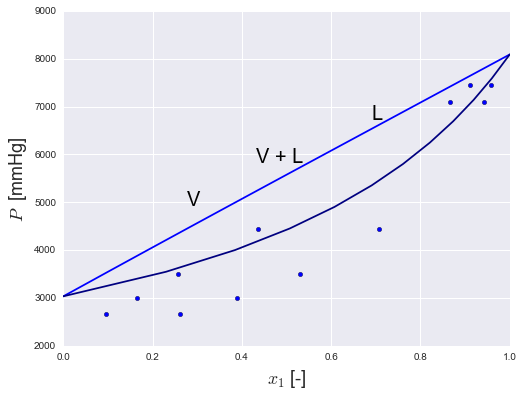

In [123]:
fig = plt.figure(figsize=(8,6))
fig.text(0.34, 0.45, "V", fontsize=20, color="k")
fig.text(0.46, 0.55, "V + L", fontsize=20, color="k")
fig.text(0.66, 0.65, "L", fontsize=20, color="k")
ax = fig.add_subplot(1,1,1)
ax.plot(xb,pb,color='blue')
#ax.scatter((1-xb),pb)
ax.plot(xd,pd,color='navy')
#ax.scatter(1-xd,pd)
ax.set_xlim([0,1])
#ax.set_ylim([0,8000])
#matplotlib.rcParams.update({'font.size': 18, 'text.usetex': True})
ax.set_xlabel(r'$x_1$ [-]', fontsize=18)
ax.set_ylabel(r'$P$  [mmHg]', fontsize=18)

## artigo
x_beranek = np.array([0.096, 0.164, 0.257, 0.437, 0.867, 0.910])
y_beranek = np.array([0.261, 0.388, 0.530, 0.707, 0.942, 0.958])
p_beranek = np.array([354, 400.5, 468.1, 591, 947.4, 993.5]) * kPatommHg

ax.scatter(x_beranek,p_beranek)
ax.scatter(y_beranek,p_beranek)

In [207]:
T = 303.14
x = 0.1
pentano = molecule({1:2,2:3})
acetona = molecule({1:1,18:1})
print(pentano.rql(),acetona.rql())

(3.8254, 3.316, -0.27839999999999865) (2.5735, 2.336, -0.3859999999999988)


In [208]:
acetona.rql()
acetona.phi_theta(pentano)
acetona.combinatorial(pentano)
print(acetona.phi,acetona.theta,pentano.phi,pentano.theta)
print(acetona.gamma,acetona.gamma_c_ln,pentano.gamma,pentano.gamma_c_ln)

0.06955010661557047 0.072591671845867 0.9304498933844295 0.927408328154133
0.953061815074 -0.0480755137648 0.999529331172 -0.000470779627054


In [209]:
acetona.psi_mod(pentano,[1,1,9])
acetona.psi_matrix

array([[ 1.        ,  1.        ,  0.20772273],
       [ 1.        ,  1.        ,  0.20772273],
       [ 0.91550812,  0.91550812,  1.        ]])

In [211]:
acetona.X_mod(pentano)
acetona.X_mod_i(pentano)
print(acetona.X)
print(acetona.Xi)

[0.4042553191489362, 0.574468085106383, 0.02127659574468085]
(array([ 0.5,  0.5]), array([ 0.4,  0.6]))


In [212]:
print(acetona.Theta_mod(pentano))

[ 0.50068365  0.45307644  0.0462399 ]


In [213]:
acetona.Gamma_k(pentano)

array([ 0.00602599,  0.0038373 ,  1.998819  ])

In [214]:
acetona.Theta_mod_i(pentano)

(array([ 0.3630137,  0.6369863]), array([ 0.51145959,  0.48854041]))

In [215]:
acetona.Gamma_k_i(pentano)

(0.41206415545737579, 0.13946930613292655, 0.0, 0.0)

In [217]:
acetona.residual(pentano)
acetona.Gamma(pentano)

0.1 
 (1.4533115266250261, 0.023563882637954413) 



array([ 4.07648873,  1.02336181])

81.96398495878864 37.94469852491993
0.1 
 (0.44942987831275194, 0.55285440179739265) 

0.1 
 [ 1.48296935  1.73669333] 
 a
0.188888888889 
 (0.62551147682412689, 0.45615299030885614) 

0.188888888889 
 [ 1.79064274  1.57332173] 
 a
0.277777777778 
 (0.8682316275752251, 0.3692479542928554) 

0.277777777778 
 [ 2.30640795  1.4378213 ] 
 a
0.366666666667 
 (1.1808810174321531, 0.29147948598162388) 

0.366666666667 
 [ 3.18015036  1.32483384] 
 a
0.455555555556 
 (1.568995210161571, 0.22240320249113166) 

0.455555555556 
 [ 4.72104393  1.23040391] 
 a
0.544444444444 
 (2.0408949412749071, 0.16179706978402628) 

0.544444444444 
 [ 7.61025683  1.15163129] 
 a
0.633333333333 
 (2.6085462461846847, 0.10968826765944767) 

0.633333333333 
 [ 13.48330752   1.0864512 ] 
 a
0.722222222222 
 (3.2889214278112373, 0.066408505725662009) 

0.722222222222 
 [ 26.70914202   1.03351421] 
 a
0.811111111111 
 (4.1061868900418634, 0.032694197904141152) 

0.811111111111 
 [ 60.60902702   0.99216021] 
 a
0.9 
 

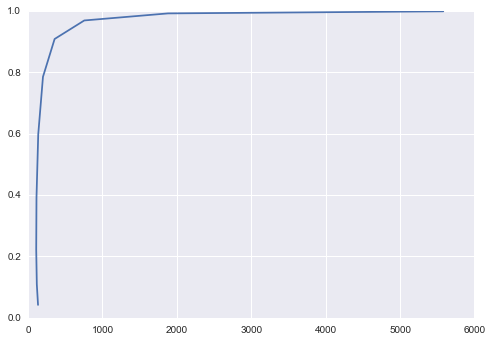

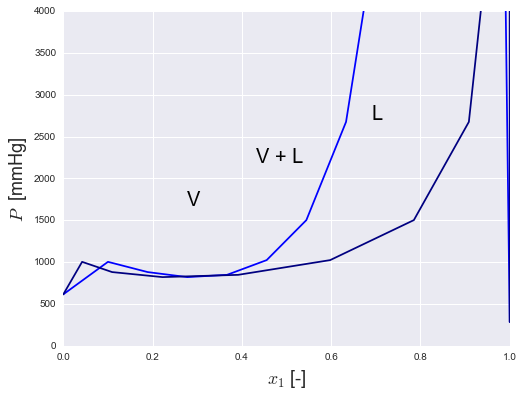

In [218]:
T = 303.14
p_sat_pent = CP.PropsSI('P','T',T,'Q',0,'nPentane') / 1000
p_sat_ace = CP.PropsSI('P','T',T,'Q',0,'acetone') / 1000
print(p_sat_pent,p_sat_ace)
guess = (0, 0)    
yk,pk = [], []
acetona, pentano = molecule({1:2,2:3}), molecule({1:1,18:1})
acetona.rql(), pentano.rql()
acetona.psi_mod(pentano,[1,1,9])
x_molar = np.linspace(0.1,0.9,10)
for x in x_molar:
    acetona.Gamma(pentano)
    print(x,'\n',acetona.y,'\n','a')
    f_l_1 = x * acetona.y[0] * p_sat_ace
    f_l_2 = (1-x) * acetona.y[1] * p_sat_pent
    #print(f_l_1, f_l_2)
    y, p =  opt.fsolve(sistema, guess)
    guess = (y, p)
    yk.append(y)
    pk.append(p)
plt.plot(pk,yk)
# Bubble point
pb, xb = [], []
pb.append([p_sat_pent]), xb.append([0])
pb.append([p for p in pk]), xb.append(x_molar)
pb.append([p_sat_ace]), xb.append([1])
pb = np.array(list([i for j in pb for i in j]))* kPatommHg
xb = np.array(list([i for j in xb for i in j]))

# Dew point
pd, xd = [], []
pd.append([p_sat_pent]), xd.append([0])
pd.append([p for p in pk]), xd.append(yk)
pd.append([p_sat_ace]), xd.append([1])
pd = np.array(list([i for j in pd for i in j]))* kPatommHg
xd = np.array(list([i for j in xd for i in j]))

fig = plt.figure(figsize=(8,6))
fig.text(0.34, 0.45, "V", fontsize=20, color="k")
fig.text(0.46, 0.55, "V + L", fontsize=20, color="k")
fig.text(0.66, 0.65, "L", fontsize=20, color="k")
ax = fig.add_subplot(1,1,1)
ax.plot(xb,pb,color='blue')
#ax.scatter((1-xb),pb)
ax.plot(xd,pd,color='navy')
#ax.scatter(1-xd,pd)
ax.set_xlim([0,1])
ax.set_ylim([0,4000])
#matplotlib.rcParams.update({'font.size': 18, 'text.usetex': True})
ax.set_xlabel(r'$x_1$ [-]', fontsize=18)
ax.set_ylabel(r'$P$  [mmHg]', fontsize=18)